# COMP90051 Project 2
**Name:** *enter your name here*

**Student ID:** *your id here*

In [287]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import collections

In [288]:
import warnings
warnings.filterwarnings('ignore')

## 0. Loading the dataset

In [289]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [290]:
seed_pool = X_pool[seed_set]
seed_pool_label = y_pool[seed_set]

In [291]:
unlabelled_set = [x for x in list(range(0,len(X_pool))) if x not in seed_set]

unlabelled_pool = X_pool[unlabelled_set]
unlabelled_label = y_pool[unlabelled_set]

In [292]:
unique, counts = np.unique(y_pool, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Alphabet_of_the_Magi' '200']
 ['Anglo-Saxon_Futhorc' '302']
 ['Arcadian' '234']
 ['Armenian' '416']
 ['Asomtavruli_(Georgian)' '390']
 ['Balinese' '252']
 ['Bengali' '452']
 ['Blackfoot_(Canadian_Aboriginal_Syllabics)' '136']
 ['Braille' '263']
 ['Burmese_(Myanmar)' '338']
 ['Cyrillic' '331']
 ['Early_Aramaic' '226']
 ['Futurama' '265']
 ['Grantha' '454']
 ['Greek' '237']
 ['Gujarati' '473']
 ['Hebrew' '221']
 ['Inuktitut_(Canadian_Aboriginal_Syllabics)' '145']
 ['Japanese_(hiragana)' '507']
 ['Japanese_(katakana)' '480']
 ['Korean' '404']
 ['Latin' '292']
 ['Malay_(Jawi_-_Arabic)' '404']
 ['Mkhedruli_(Georgian)' '409']
 ['N_Ko' '331']
 ['Ojibwe_(Canadian_Aboriginal_Syllabics)' '128']
 ['Sanskrit' '410']
 ['Syriac_(Estrangelo)' '229']
 ['Tagalog' '162']
 ['Tifinagh' '549']]


## 1. Applying logistic regression

In [293]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    model = LogisticRegression(**args).fit(X,y)
    return model

In [294]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    score = model.score(Xt,yt)

    return score

In [ ]:
# Train Models
full_pool_LR= train_logistic_regression(X_pool,y_pool)
seed_pool_LR= train_logistic_regression(seed_pool,seed_pool_label)

In [ ]:
full_pool_train_acc = evaluate_logistic_regression_accuracy(X_pool,y_pool,full_pool_LR)
full_pool_test_acc = evaluate_logistic_regression_accuracy(X_test,y_test,full_pool_LR)

print("Train Accuracy for full pool: ",full_pool_train_acc)
print("Test Accuracy for full pool: ",full_pool_test_acc)

In [ ]:
seed_pool_train_acc = evaluate_logistic_regression_accuracy(seed_pool,seed_pool_label,seed_pool_LR)
seed_pool_test_acc = evaluate_logistic_regression_accuracy(X_test,y_test,seed_pool_LR)

print("Train Accuracy for seed pool: ",seed_pool_train_acc)
print("Test Accuracy for seed pool: ",seed_pool_test_acc)

In [ ]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

train_vals = [full_pool_train_acc,seed_pool_train_acc]
rects1 = ax.bar(ind, train_vals, width)
test_vals = [full_pool_test_acc,seed_pool_test_acc]
rects2 = ax.bar(ind+width, test_vals, width)

ax.set_ylabel('Accuracy')
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('Full Pool', 'Seed Pool') )
ax.legend( (rects1[0], rects2[0]), ('Train', 'Test'),loc = 1 )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, round(h,3),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.title("Logistic Regression Accuracy")


plt.show()

## 2. Active learning framework with Random selection

In [295]:
def random_select(X, model):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    score = [random.uniform(0, 1) for i in range(len(X))]

    return score

In [365]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    
    L_X = X_pool[seed_ids]
    L_y = y_pool[seed_ids]
    
    modellist = []
    
    pbar = tqdm(total = (max_size-len(L_X))/batch_size)
    
    while len(L_X) <= max_size:

        
        #U_ids = [x for x in list(range(0,len(X_pool))) if x not in seed_ids]
        U_ids = np.setdiff1d(list(range(0,len(X_pool))), seed_ids)
        
        U_X = X_pool[U_ids]
        U_y = y_pool[U_ids]
        
        #print(len(U_X))

        model = train_func(L_X,L_y,**args)
        score = select_func(U_X,model)
        
        r = sorted(range(len(score)), key=lambda k: score[k],reverse=True)[:batch_size]

        try:
            modellist.append([model[1],len(L_X)])

        except:
            modellist.append([model,len(L_X)])
 

        L_X = np.append(L_X, U_X[r],axis = 0)
        L_y = np.append(L_y, U_y[r],axis = 0)
        
        seed_ids = seed_ids + list(U_ids[r])

        print(len(set(seed_ids)))
        pbar.update(1)
        
    pbar.close()
    
    return modellist

In [358]:
np.setdiff1d(list(range(0,len(X_pool))), seed_set)

array([   0,    1,    2, ..., 9637, 9638, 9639])

In [364]:
[i for i in range(0,len(X_pool))][-1]

9639

In [366]:
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch,max_iter = 100)

  2%|▏         | 1/45.0 [00:00<00:32,  1.37it/s]360
  4%|▍         | 2/45.0 [00:01<00:28,  1.53it/s]420
  7%|▋         | 3/45.0 [00:01<00:25,  1.62it/s]480
  9%|▉         | 4/45.0 [00:02<00:26,  1.52it/s]540
 11%|█         | 5/45.0 [00:03<00:25,  1.56it/s]600
 13%|█▎        | 6/45.0 [00:03<00:24,  1.57it/s]660
 16%|█▌        | 7/45.0 [00:04<00:26,  1.45it/s]720
 18%|█▊        | 8/45.0 [00:05<00:25,  1.46it/s]780
 20%|██        | 9/45.0 [00:06<00:24,  1.45it/s]840
 22%|██▏       | 10/45.0 [00:06<00:25,  1.36it/s]900
 24%|██▍       | 11/45.0 [00:07<00:24,  1.37it/s]960
 27%|██▋       | 12/45.0 [00:08<00:24,  1.36it/s]1020
 29%|██▉       | 13/45.0 [00:09<00:25,  1.23it/s]1080
 31%|███       | 14/45.0 [00:10<00:26,  1.19it/s]1140


KeyboardInterrupt: 

In [299]:
accuracy = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_random]
samples = [model[1] for model in models_random]

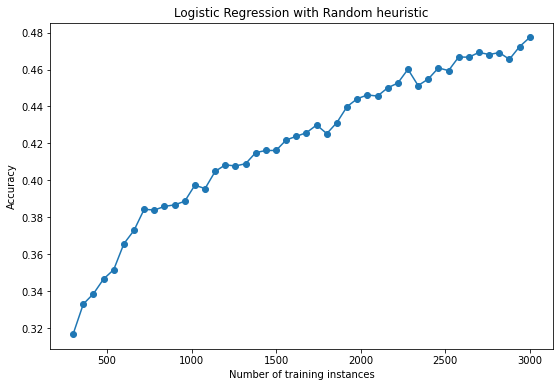

In [300]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(samples,accuracy,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Random heuristic")


plt.show()

## 3. Uncertainty sampling

In [301]:
def ENTROPY(probs):
    return -probs.dot(np.log2(probs))

def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """

    
    probs = model.predict_proba(X)
    
    result = np.apply_along_axis(ENTROPY, 1, probs)
    
    return result


In [302]:
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch,max_iter = 100)

46it [01:18,  1.72s/it]


In [303]:
accuracy = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_us]
samples = [model[1] for model in models_us]

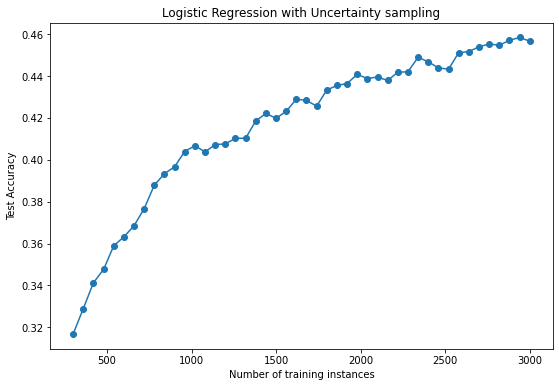

In [304]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(samples,accuracy,"o-")

ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Uncertainty sampling")


plt.show()

In [ ]:
max(accuracy)

## 4. Query by committee

In [319]:
# don't forget to provide function descriptive comments, like those provided in templates above

def query_by_committee_vote_entropy(X, model, **args):

    result = [clf.predict(X) for clf in model[0]]

    n = len(model[0])

    vote = [list(collections.Counter(x).values()) for x in zip(*result)]

    vote_entropy = [sum([(freq/n)*np.log2(freq/n) for freq in instance])*(-1) for instance in vote]


    return vote_entropy


def query_by_committee_soft_vote_entropy(X, model, **args):
    
    result = [clf.predict_proba(X) for clf in model[0]]

    n = len(model[0])

    zipped = [x for x in zip(*result)]
    prob_list = [(instance[1] + instance[0])/n for instance in zipped]

    soft_vote_entropy = np.apply_along_axis(ENTROPY, 1, prob_list)

    return soft_vote_entropy


def query_by_committee_KL(X, model, **args):
    result = [clf.predict_proba(X) for clf in model[0]]
    n = len(model[0])

    zipped = [x for x in zip(*result)]
    committee = [(instance[1] + instance[0])/n for instance in zipped]

    KL = [sum([sum(member*np.log2(member/committee[index])) for member in zipped[index]])/n  for index in range(len(X))]


    return KL

In [311]:
def train_committee(X, y,ensemble_size = 2, **args):

    #random.seed(1)
    index = range(len(X))

    bagging_models = []
    for i in range(ensemble_size):
        bootstrap_index = random.choices(index, k = len(X))
        bagging_models.append(train_logistic_regression(X[bootstrap_index],y[bootstrap_index],**args))
    
    lr_model = train_logistic_regression(X, y,**args)

    return [bagging_models,lr_model]

In [307]:
models = train_committee(seed_pool,seed_pool_label)

In [327]:
score = query_by_committee_vote_entropy(seed_pool,models)[:10]

In [325]:
sorted(range(len(score)), key=lambda k: score[k],reverse=True)

[3, 4, 0, 1, 2, 5, 6, 7, 8, 9]

In [368]:
batch = 60
max_size = 3000

In [369]:
models_ve = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee, 
                                 query_by_committee_vote_entropy, 
                                 max_size, batch, max_iter = 100)

# models_sve = pool_based_active_learning(X_pool, y_pool, seed_set, 
#                                  train_committee, 
#                                  query_by_committee_soft_vote_entropy, 
#                                  max_size, batch, max_iter = 100)


# models_kl = pool_based_active_learning(X_pool, y_pool, seed_set, 
#                                  train_committee, 
#                                  query_by_committee_KL, 
#                                  max_size, batch, max_iter = 100)



 31%|███       | 14/45.0 [00:34<01:16,  2.46s/it]


  2%|▏         | 1/45.0 [00:01<01:24,  1.92s/it]360


  4%|▍         | 2/45.0 [00:03<01:22,  1.93s/it]420


  7%|▋         | 3/45.0 [00:05<01:21,  1.95s/it]480


  9%|▉         | 4/45.0 [00:07<01:21,  2.00s/it]540


 11%|█         | 5/45.0 [00:10<01:23,  2.08s/it]600


 13%|█▎        | 6/45.0 [00:12<01:23,  2.14s/it]660


 16%|█▌        | 7/45.0 [00:14<01:24,  2.22s/it]720


 18%|█▊        | 8/45.0 [00:17<01:23,  2.25s/it]780


 20%|██        | 9/45.0 [00:19<01:22,  2.29s/it]840


 22%|██▏       | 10/45.0 [00:21<01:21,  2.33s/it]900


 24%|██▍       | 11/45.0 [00:24<01:20,  2.36s/it]960


 27%|██▋       | 12/45.0 [00:26<01:19,  2.42s/it]1020


 29%|██▉       | 13/45.0 [00:29<01:18,  2.46s/it]1080


 31%|███       | 14/45.0 [00:32<01:17,  2.51s/it]1140


 33%|███▎      | 15/45.0 [00:34<01:16,  2.56s/it]1200


 36%|███▌      | 16/45.0 [00:37<01:15,  2.60s/it]1260


 38%|███▊      | 17/45.0 [00:40<01:15,  2.70s/it]1320


 40%|████     

In [370]:
accuracy_ve = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_ve]
#accuracy_sve = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_sve]
#accuracy_kl = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_kl]

samples = [model[1] for model in models_ve]

In [371]:
max(accuracy_ve)

0.4969917012448133

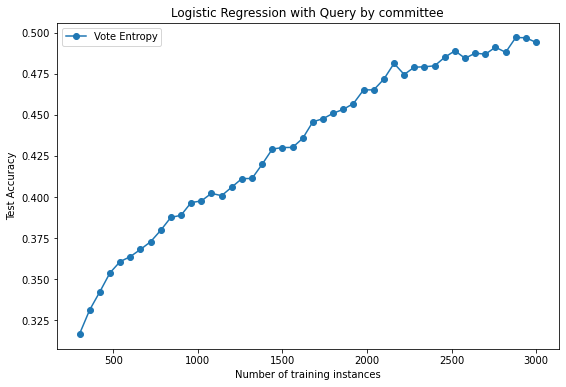

In [372]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(samples,accuracy_ve,"o-",label = "Vote Entropy")
#ax.plot(samples,accuracy_sve,"o-",label = "Soft Vote Entropy")
#ax.plot(samples,accuracy_kl,"o-",label = "Kullback-Leibler")


ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Query by committee")
plt.legend()

plt.show()

In [ ]:
## your code here for training, evaluation, and plotting code

## 5. Hierarchical sampling

In [ ]:
## your code